# Monitoraggio della qualità di trasmissione di un dispositivo nella rete LoRaWAN

## Obiettivi:

*   A partire dal dataset costituito da tutti i pacchetti ricevuti dai gateway, classificare la qualità di ogni trasmissione (che chiameremo stress) come *scarsa*, *buona* o *ottima*
*   Sempre a partire da questo dataset, identificare in quali giornate si sono verificate eventuali anomalie

## Obiettivo 1: classificazione dello stress

Possiamo definire un dispositivo LoRaWAN come *stressato* quando lavora al limite delle sue capacità di trasmissione. In altre parole quando sta lottando contro il rumore e la bassa potenza, cercando di far arrivare i pacchetti a destinazione. Questo stato è spesso caratterizzato da un alto spreading factor, da una bassa potenza del segnale e da un basso SNR. Tuttavia queste quantità, prese singolarmente, non sono sufficienti a determinare se il dispositivo è *stressato* o meno. A causa dell'algoritmo ADR (Adaptive Data Rate), alcuni dispositivi possono trasmettere a bassa potenza quando il segnale appare essere forte e stabile. In questo caso la bassa potenza non è sintomo di *stress* del dispositivo, ma, al contrario, di una buona qualità del segnale.

Si ritiene quindi necessario adottare tecniche di *machine learning* (un algoritmo k-means, in questo caso) per adattare la classificazione alle diverse features del segnale e ai diversi scenari possibili durante la trasmissione.

In [ ]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

Iniziamo caricando il dataset:

In [ ]:
data = pd.read_csv("drive/MyDrive/Colab Notebooks/data/fields.csv")
data = data.dropna() # rimozione delle celle vuote
display(data)

,DEV_ADDR,DEV_EUI,CREATED_AT,CODR,PORT,SF,BW,FREQUENCY,FCnt,GATEWAY,SNR,SNR_MARGIN,RSSIC,RSSIS,SIZE,FInc,LOST
0,260B5FB7,70B3D57ED0061BB2,2025-04-14T15:08:03.563776492Z,4/5,10,7,125000,867300000,1594,eui-ac1f09fffe0579f9,-8.75,-1.25,-121.0,-121.0,19,1.0,0.0
1,260B5FB7,70B3D57ED0061BB2,2025-04-14T15:08:03.563776492Z,4/5,10,7,125000,867300000,1594,lab3841-main,10.20,17.70,-82.0,-82.0,19,1.0,0.0
2,260B1B6E,70B3D57ED0058830,2025-04-15T08:42:32.199220058Z,4/5,10,7,125000,867900000,836,lab3841-main,10.00,17.50,-75.0,-75.0,31,1.0,0.0
3,27FD854E,70B3D57ED0053F8A,2025-04-16T06:02:28.331948349Z,4/5,10,9,125000,867300000,119,packetbroker,-0.50,12.00,-114.0,-114.0,14,1.0,0.0
4,260B1B6E,70B3D57ED0058830,2025-04-17T05:42:34.634611755Z,4/5,10,7,125000,868500000,1018,lab3841-main,8.20,15.70,-77.0,-77.0,31,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444211,260BA30F,70B3D57ED00654B8,2025-04-02T01:06:22.331236132Z,4/5,10,12,125000,867900000,34,lab3841-indoor,-2.00,18.00,-103.0,-103.0,19,1.0,0.0
444212,260BA30F,70B3D57ED00654B8,2025-04-02T01:06:22.331236132Z,4/5,10,12,125000,867900000,34,eui-ac1f09fffe057a05,-21.00,-1.00,-137.0,-137.0,19,1.0,0.0
444213,260B8146,70B3D57ED0061BB2,2025-04-02T01:06:58.254308834Z,4/5,10,7,125000,868100000,1082,lab3841-main,9.80,17.30,-75.0,-75.0,19,1.0,0.0
444214,27FD854A,70B3D57ED00654BD,2025-04-02T01:09:27.434304914Z,4/5,10,11,125000,868100000,15,eui-ac1f09fffe0cd25d,-2.25,15.25,-109.0,-109.0,45,1.0,0.0


Andiamo ora a selezionare le features (colonne) sulle quali vogliamo basare la nostra classificazione. Nel nostro contesto, possono essere significativi:


*   Lo spreading factor (SF)
*   La potenza del segnale (RSSIC)
*   Il rapporto segnale-rumore (SNR)




In [ ]:
features = ['SF', 'SNR', 'RSSIC']
X = data[features]
display(X)

,SF,SNR,RSSIC
0,7,-8.75,-121.0
1,7,10.20,-82.0
2,7,10.00,-75.0
3,9,-0.50,-114.0
4,7,8.20,-77.0
...,...,...,...
444211,12,-2.00,-103.0
444212,12,-21.00,-137.0
444213,7,9.80,-75.0
444214,11,-2.25,-109.0


Procediamo poi normalizzando i dati. Tutti i valori sono infatti su scale diverse: normalizzando possiamo fare in modo che abbiano tutti la stessa media (0) e la stessa varianza (1):

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
display(X_scaled)

array([[-0.840914  , -0.76843124, -0.9290998 ],
       [-0.840914  ,  1.22494705,  1.10774442],
       [-0.840914  ,  1.20390876,  1.47333185],
       ...,
       [-0.840914  ,  1.18287046,  1.47333185],
       [ 1.48184229, -0.08468671, -0.3023785 ],
       [-0.26022493,  1.077679  ,  1.47333185]])

Procediamo infine con la classificazione vera e propria: essa verrà fatta tramite un *algoritmo di clustering k-means*. Il clustering k-means è un algoritmo che divide i dati in k-insiemi, basandosi sulla loro distanza euclidea nello spazio. Nel nostro caso avremo k=3, e quindi divideremo i dati negli insiemi *scarso*, *buono* e *ottimo*

Supponiamo ora che:


*   SF sia la coordinata x
*   SNR sia la coordinata y
*   RSSIC sia la coordinata z

E mostriamo i valori nello spazio:



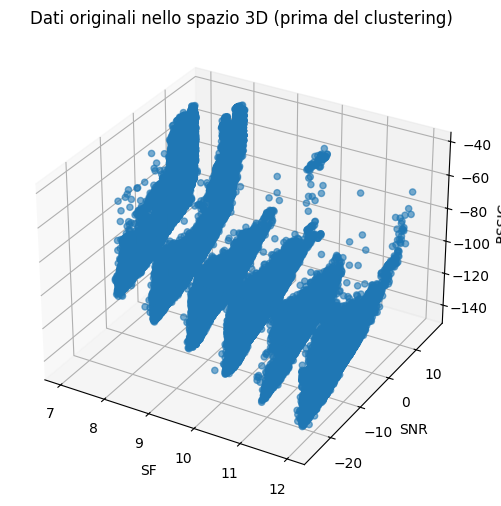

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X['SF'], X['SNR'], X['RSSIC'], alpha=0.6)

ax.set_xlabel('SF')
ax.set_ylabel('SNR')
ax.set_zlabel('RSSIC')
ax.set_title('Dati originali nello spazio 3D (prima del clustering)')
plt.show()

Eseguiamo ora l'algoritmo di clustering: esso assegnerà ad ogni punto (pacchetto) un indice compreso tra 0 e 2, corrispondente al gruppo che gli è stato assegnato. Possiamo generare quindi una nuova colonna "STRESS"

In [ ]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=3, n_init=10)
idx = kmeans.fit_predict(X_scaled)
data['STRESS'] = idx

display(data)

,DEV_ADDR,DEV_EUI,CREATED_AT,CODR,PORT,SF,BW,FREQUENCY,FCnt,GATEWAY,SNR,SNR_MARGIN,RSSIC,RSSIS,SIZE,FInc,LOST,STRESS
0,260B5FB7,70B3D57ED0061BB2,2025-04-14T15:08:03.563776492Z,4/5,10,7,125000,867300000,1594,eui-ac1f09fffe0579f9,-8.75,-1.25,-121.0,-121.0,19,1.0,0.0,0
1,260B5FB7,70B3D57ED0061BB2,2025-04-14T15:08:03.563776492Z,4/5,10,7,125000,867300000,1594,lab3841-main,10.20,17.70,-82.0,-82.0,19,1.0,0.0,2
2,260B1B6E,70B3D57ED0058830,2025-04-15T08:42:32.199220058Z,4/5,10,7,125000,867900000,836,lab3841-main,10.00,17.50,-75.0,-75.0,31,1.0,0.0,2
3,27FD854E,70B3D57ED0053F8A,2025-04-16T06:02:28.331948349Z,4/5,10,9,125000,867300000,119,packetbroker,-0.50,12.00,-114.0,-114.0,14,1.0,0.0,0
4,260B1B6E,70B3D57ED0058830,2025-04-17T05:42:34.634611755Z,4/5,10,7,125000,868500000,1018,lab3841-main,8.20,15.70,-77.0,-77.0,31,1.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444211,260BA30F,70B3D57ED00654B8,2025-04-02T01:06:22.331236132Z,4/5,10,12,125000,867900000,34,lab3841-indoor,-2.00,18.00,-103.0,-103.0,19,1.0,0.0,1
444212,260BA30F,70B3D57ED00654B8,2025-04-02T01:06:22.331236132Z,4/5,10,12,125000,867900000,34,eui-ac1f09fffe057a05,-21.00,-1.00,-137.0,-137.0,19,1.0,0.0,1
444213,260B8146,70B3D57ED0061BB2,2025-04-02T01:06:58.254308834Z,4/5,10,7,125000,868100000,1082,lab3841-main,9.80,17.30,-75.0,-75.0,19,1.0,0.0,2
444214,27FD854A,70B3D57ED00654BD,2025-04-02T01:09:27.434304914Z,4/5,10,11,125000,868100000,15,eui-ac1f09fffe0cd25d,-2.25,15.25,-109.0,-109.0,45,1.0,0.0,1


Possiamo ora mostrare i dati nello spazio in base al gruppo di appartenenza:

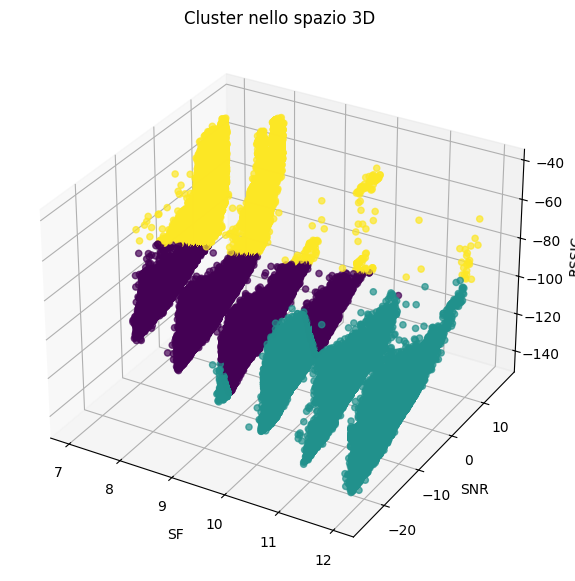

In [ ]:
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    data['SF'], data['SNR'], data['RSSIC'],
    c=idx, cmap='viridis', alpha=0.7, depthshade=True, zorder=1
)

ax.set_xlabel('SF')
ax.set_ylabel('SNR')
ax.set_zlabel('RSSIC')
ax.set_title('Cluster nello spazio 3D')
plt.show()

Oltre a raggruppare i nostri dati, l'algoritmo k-means ci genera i centroidi (uno per ogni gruppo), ovvero i punti che rappresentano la media delle coordinate di tutti i punti degli insiemi:

In [ ]:
centroids_scaled = kmeans.cluster_centers_
display(centroids_scaled)

array([[-0.28952191, -0.24682401, -0.53022066],
       [ 1.66068816, -1.22956507, -0.76077687],
       [-0.72784825,  1.19385798,  1.274802  ]])

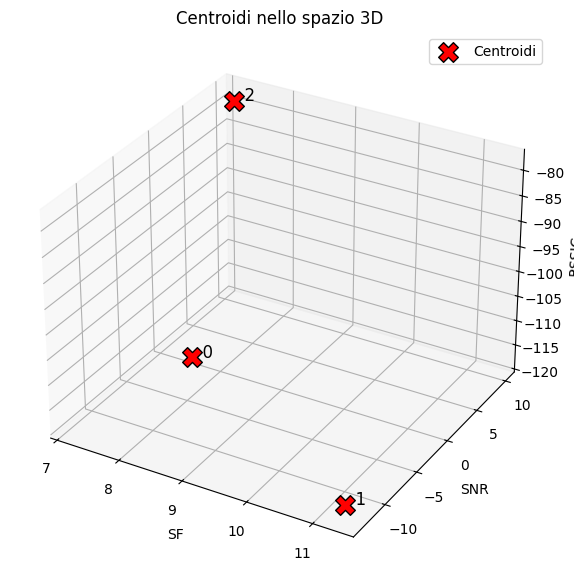

In [ ]:
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
centroids_original = scaler.inverse_transform(centroids_scaled)

scatter = ax.scatter(
    centroids_original[:, 0], centroids_original[:, 1], centroids_original[:, 2],
    c='red', s=200, marker='X', edgecolor='k', label='Centroidi',
    depthshade=False, zorder=1
)

for i, (x, y, z) in enumerate(centroids_original):
    ax.text(x, y, z, f'  {i}', color='black', fontsize=12)

ax.set_xlabel('SF')
ax.set_ylabel('SNR')
ax.set_zlabel('RSSIC')
ax.set_title('Centroidi nello spazio 3D')
ax.legend()
plt.show()

Dal plot precedente possiamo notare che:


*   Il cluster 2 corrisponde a basso SF, alto SNR e alto RSSIC, quindi è associabile al gruppo *ottimo*
*   Il cluster 1 corrisponde a alto SF, basso SNR e basso RSSIC,
quindi è associabile al gruppo *scarso*
*   Il cluster 0 corrisponde a basso SF, medio SNR e medio RSSIC,
quindi è associabile al gruppo *buono*


I centroidi sono di fondamentale importanza. Ogni volta che arriva un pacchetto "nuovo", per poterlo classificare all'interno di un gruppo possiamo infatti misurare la distanza del nuovo punto dai 3 centroidi, e poi "assegnargli" il centroide più vicino:

In [ ]:
# SF = 7
# SNR = 10
# RSSIC = -80
new_point1 = [7, 10, -80]

# SF = 11
# SNR = -5
# RSSIC = -115
new_point2 = [12, -20, -140]

# SF = 10
# SNR = 0
# RSSIC = -115
new_point3 = [10, 0, -115]

def euclidean(p1, p2): # funzione per calcolare la distanza
    return math.sqrt(sum((a-b)**2 for a,b in zip(p1,p2)))

new_point = new_point1

distances = [euclidean(new_point, c) for c in centroids_original] # calcoliamo la distanza da ogni cluster
assigned_cluster = distances.index(min(distances)) # prendiamo il cluster il cui centroide è a minima distanza
display(assigned_cluster)

2

Per concludere, questa soluzione garantisce un **meccanismo estremamente efficiente sia a livello computazionale che a livello di memoria**:


*   In memoria è necessario solamente salvare le coordinate dei centroidi ed eventualmente i valori di media e varianza (per effettuare la normalizzazione)
*   La classificazione non è altro che il calcolo di *k* distanze euclidee
*   I centroidi, a lungo termine, andrebbero aggiornati, ma siccome il nostro dataset è molto vasto e ben distribuito, la loro posizione non dovrebbe subire grandi mutamenti nel tempo

Per avere una statistica giornaliera, possiamo assegnare ad ogni dispositivo lo stress che è stato più presente nei suoi pacchetti giornalieri (ovvero la moda). Ciò verrà fatto nel codice successivo.


## Obiettivo 2: rilevamento di anomalie

L'obiettivo è quello di classificare il comportamento di ogni dispositivo quotidianamente, in modo tale da comprendere se sta riscontrando anomalie. Siccome il nostro dataset iniziale possiede i pacchetti provenienti da ogni gateway, è necessario raggruppare i dati, in modo tale da avere una singola entry quotidiana per ogni dispositivo. Le features finali che vogliamo ottenere sono:


*   Lo *stress* quotidiano
*   La percentuale di pacchetti persi
*   La percentuali di pacchetti inviati su una porta dispari (dovuti a un pacchetto perso)
*   La percentuale di reboots
*   La percentuale di rejoin alla rete

Il codice seguente permette di ottenere il nuovo dataset a partire da quello precedentemente già classificato:



In [ ]:
data_daily = data.reset_index(drop=True)
data_daily = data_daily.sort_values(['DEV_EUI','CREATED_AT'])
# associamo ad ogni index del cluster un punteggio a nostra scelta, ad esempio
# cluster 2, basso stress: 8
# cluster 1, alto stress: 10
# cluster 0, medio stress, 9
data_daily['STRESS'] = data_daily['STRESS'].map({2: 8, 1: 10, 0: 9})

# funzione per calcolare, dato un pacchetto, l'incremento del frame counter
def compute_finc(df):
    df = df.drop(columns=['FInc'])
    df_unique = df.drop_duplicates(subset=['DEV_EUI', 'CREATED_AT'])
    df_unique = df_unique.sort_values(['DEV_EUI', 'CREATED_AT'])
    df_unique['FInc'] = df_unique.groupby('DEV_EUI')['FCnt'].diff().fillna(1)
    df = df.merge(
        df_unique[['DEV_EUI', 'CREATED_AT', 'FInc']],
        on=['DEV_EUI', 'CREATED_AT'],
        how='left'
    )
    #df['FInc'] = df['FInc'].clip(lower=1)
    df['LOST'] = np.where(df['FInc'] >= 1, df['FInc'] - 1, 0)
    return df
data_daily = compute_finc(data_daily)

# calcolo della moda giornaliera dello stress
data_daily['DATE'] = pd.to_datetime(data_daily['CREATED_AT']).dt.date
mode_stress = (
    data_daily.groupby(['DEV_EUI', 'DATE'])['STRESS']
      .agg(lambda x: x.mode().iloc[0])
      .reset_index()
      .rename(columns={'STRESS': 'STRESS_DAY'})
)
data_daily = data_daily.merge(mode_stress, on=['DEV_EUI', 'DATE'], how='left')

# raggruppamento per dispositivo e pacchetto
data_daily = data_daily.groupby(['DEV_EUI', 'CREATED_AT'], as_index=False).agg({
    'DATE': 'first',
    'STRESS_DAY': 'first',
    'PORT': 'first',
    'FCnt': 'first',
    'FInc': 'first',
    'LOST': 'first'
})

# raggruppamente per dispositivo e data, con calcolo delle statistiche
def count_port_30(series):
    return (series == 30).sum()

def count_port_even(series):
    return series.isin([10, 20]).sum()

def count_port_odd(series):
    return series[series % 2 == 1].count()

data_daily = data_daily.groupby(['DEV_EUI', 'DATE']).agg(
    STRESS_DAY=('STRESS_DAY', 'first'),
    PORT_30=('PORT', count_port_30),
    PORT_EVEN=('PORT', count_port_even),
    PORT_ODD=('PORT', count_port_odd),
    TOTAL_LOST=('LOST', 'sum'),
    TOTAL_RECEIVED=('PORT', 'count'),
    NUM_JOIN=('FInc', lambda x: (x < 1).sum())
).reset_index()

# calcolo delle percentuali
data_daily['TOTAL_PACKETS'] = data_daily['TOTAL_LOST']+data_daily['TOTAL_RECEIVED']
data_daily['PERC_LOST'] = data_daily['TOTAL_LOST']/data_daily['TOTAL_PACKETS']
data_daily['PERC_ODD_PORT'] = data_daily['PORT_ODD']/data_daily['TOTAL_PACKETS']
data_daily['PERC_REBOOTS'] = data_daily['PORT_30']/data_daily['TOTAL_PACKETS']
data_daily['PERC_JOIN'] = data_daily['NUM_JOIN']/data_daily['TOTAL_PACKETS']
data_daily = data_daily[['DEV_EUI', 'DATE', 'STRESS_DAY', 'PERC_LOST', 'PERC_ODD_PORT', 'PERC_REBOOTS', 'PERC_JOIN']]

display(data_daily)


,DEV_EUI,DATE,STRESS_DAY,PERC_LOST,PERC_ODD_PORT,PERC_REBOOTS,PERC_JOIN
0,70B3D57ED004FE15,2025-01-29,9,0.000000,0.0,0.0,0.000000
1,70B3D57ED004FE15,2025-01-30,9,0.013793,0.0,0.0,0.000000
2,70B3D57ED004FE15,2025-01-31,9,0.000000,0.0,0.0,0.000000
3,70B3D57ED004FE15,2025-02-01,9,0.000000,0.0,0.0,0.000000
4,70B3D57ED004FE15,2025-02-02,9,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...
2987,70B3D57ED006FF14,2025-07-24,10,0.394737,0.0,0.0,0.078947
2988,70B3D57ED006FF14,2025-07-25,10,0.473684,0.0,0.0,0.078947
2989,70B3D57ED006FF14,2025-07-26,10,0.512195,0.0,0.0,0.048780
2990,70B3D57ED006FF14,2025-07-27,10,0.341463,0.0,0.0,0.073171


Possiamo ora proseguire come in precedenza, applicando un algoritmo di clustering che dividerà il nostro dataset in due gruppi: cluster anomalo e cluster non anomalo. Per farlo iniziamo selezionando le features, in questo caso quello di interesse sono:


*   Percentuale di pacchetti persi
*   Percentuale di reboots
*   Percentuale di rejoin



In [ ]:
features = ['PERC_LOST', 'PERC_REBOOTS', 'PERC_JOIN']
X = data_daily[features]
display(X)

,PERC_LOST,PERC_REBOOTS,PERC_JOIN
0,0.000000,0.0,0.000000
1,0.013793,0.0,0.000000
2,0.000000,0.0,0.000000
3,0.000000,0.0,0.000000
4,0.000000,0.0,0.000000
...,...,...,...
2987,0.394737,0.0,0.078947
2988,0.473684,0.0,0.078947
2989,0.512195,0.0,0.048780
2990,0.341463,0.0,0.073171


Procediamo normalizzando e mostrando i dati a grafico:

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

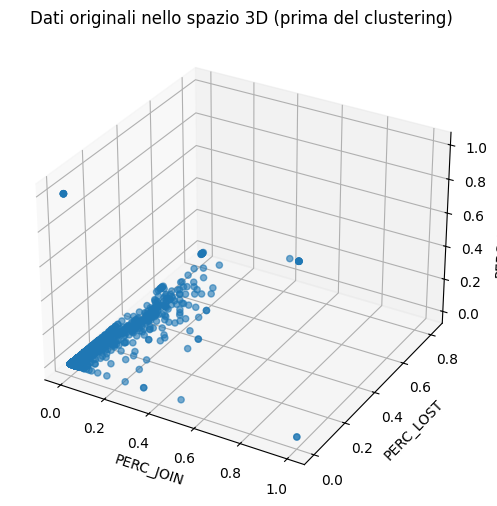

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X['PERC_JOIN'], X['PERC_LOST'], X['PERC_REBOOTS'], alpha=0.6)

ax.set_xlabel('PERC_JOIN')
ax.set_ylabel('PERC_LOST')
ax.set_zlabel('PERC_REBOOTS')
ax.set_title('Dati originali nello spazio 3D (prima del clustering)')
plt.show()

Applichiamo ora il k-means impostando k=2, siccome avremo solamente due gruppi (anomale e non anomalo):

In [ ]:
k = 2
kmeans = KMeans(n_clusters=k, random_state=3, n_init=1)
idx = kmeans.fit_predict(X_scaled)
data_daily['ANOMALY'] = idx

display(data_daily)

,DEV_EUI,DATE,STRESS_DAY,PERC_LOST,PERC_ODD_PORT,PERC_REBOOTS,PERC_JOIN,ANOMALY
0,70B3D57ED004FE15,2025-01-29,9,0.000000,0.0,0.0,0.000000,0
1,70B3D57ED004FE15,2025-01-30,9,0.013793,0.0,0.0,0.000000,0
2,70B3D57ED004FE15,2025-01-31,9,0.000000,0.0,0.0,0.000000,0
3,70B3D57ED004FE15,2025-02-01,9,0.000000,0.0,0.0,0.000000,0
4,70B3D57ED004FE15,2025-02-02,9,0.000000,0.0,0.0,0.000000,0
...,...,...,...,...,...,...,...,...
2987,70B3D57ED006FF14,2025-07-24,10,0.394737,0.0,0.0,0.078947,1
2988,70B3D57ED006FF14,2025-07-25,10,0.473684,0.0,0.0,0.078947,1
2989,70B3D57ED006FF14,2025-07-26,10,0.512195,0.0,0.0,0.048780,1
2990,70B3D57ED006FF14,2025-07-27,10,0.341463,0.0,0.0,0.073171,1


E mostriamo i nuovi risultati:

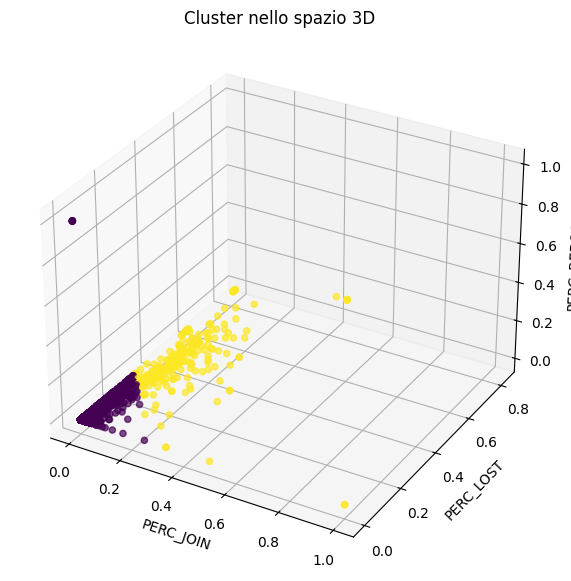

In [ ]:
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    data_daily['PERC_JOIN'], data_daily['PERC_LOST'], data_daily['PERC_REBOOTS'],
    c=idx, cmap='viridis', alpha=0.7, depthshade=True, zorder=1
)

ax.set_xlabel('PERC_JOIN')
ax.set_ylabel('PERC_LOST')
ax.set_zlabel('PERC_REBOOTS')
ax.set_title('Cluster nello spazio 3D')
plt.show()

Come in precedenza, possiamo estrarre i centroidi e utilizzarli per le future previsioni:

In [ ]:
centroids_scaled = kmeans.cluster_centers_
display(centroids_scaled)

array([[-0.25642058, -0.03935126, -0.15238908],
       [ 2.72883383,  0.41877699,  1.6217281 ]])

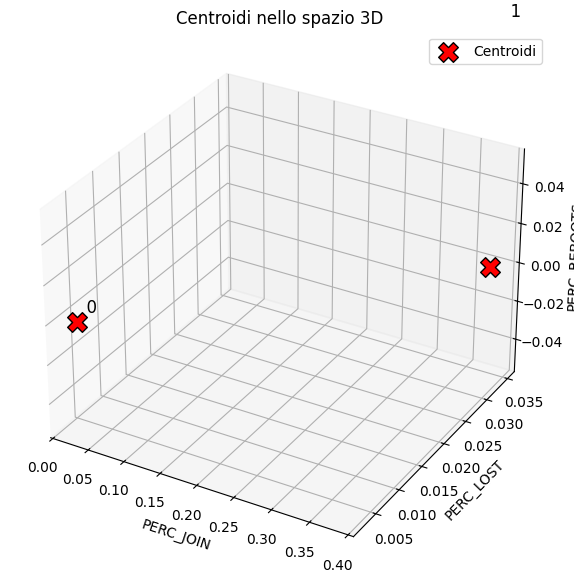

In [ ]:
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
centroids_original = scaler.inverse_transform(centroids_scaled)

scatter = ax.scatter(
    centroids_original[:, 0], centroids_original[:, 1],
    c='red', s=200, marker='X', edgecolor='k', label='Centroidi',
    depthshade=False, zorder=1
)

for i, (x, y, z) in enumerate(centroids_original):
    ax.text(x, y, z, f'  {i}', color='black', fontsize=12)

ax.set_xlabel('PERC_JOIN')
ax.set_ylabel('PERC_LOST')
ax.set_zlabel('PERC_REBOOTS')
ax.set_title('Centroidi nello spazio 3D')
ax.legend()
plt.show()

In un sistema finale, il potenziale meccanismo è il seguente:


*   All'arrivo del pacchetto, viene calcolato lo stress (sfruttando il precedente clustering) e viene salvato all'interno di un database
*   Quotidianamente viene generata la tabella daily, che per ogni dispositivo ne mostra le statistiche (stress giornaliero, pacchetti persi, reboots, ecc...)
*   Da questa tabella, ogni entry viene classificata come anomala o non, permettendo di rilevare se il dispositivo ha riscontrato anomalie durante la giornata

